## Sawtooth demo

In [1]:
# setup logging

import elfpy.utils.outputs as output_utils

output_utils.setup_logging(log_filename="../../.logging/sawtooth_demo.log")

In [2]:
from elfpy.utils.parse_config import parse_simulation_config
from elfpy.simulators import Simulator

config_dict = {
    'title': 'demo simulation config',
    'market': {
        'min_target_liquidity': 1_000_000.0,
        'max_target_liquidity': 10_000_000.0,
        'min_vault_age': 0,
        'max_vault_age': 1,
        'vault_apr': {"type": "uniform", "low": 0.001, "high": 0.9},
        'base_asset_price': 1
    },
    'amm': {
        'pricing_model_name': 'Hyperdrive',
        'min_fee': 0.1,
        'max_fee': 0.5,
        'min_pool_apr': 0.02,
        'max_pool_apr': 0.9,
        'floor_fee': 0,
    },
    'simulator': {
        'num_trading_days': 180,
        'num_blocks_per_day': 7_200,
        'token_duration': 0.2465753424657534,
        'precision': 64,
        'agent_policies': [],
        'shuffle_users': True,
        'init_lp': True,
        'random_seed': 123,
        'logging_level': 'debug'
    }
}

In [3]:
import numpy as np

import elfpy.utils.parse_config as config_utils

override_dict = {
    "target_liquidity": 1e7,
    "fee_percent": 0.1,
    "target_pool_apr": 0.05,
    "num_trading_days": 20,
    "num_blocks_per_day": 1,  # temporarily set it to 1 block a day for testing
}
ramp = [0.05,] * 10 # constant for a bit
ramp.extend(np.linspace(start=0.05, stop=0.1, num=5).tolist()) # jump up quickly
ramp.extend([0.1,] * int(override_dict['num_trading_days'] - 15)) # constant the rest of the time
override_dict["vault_apr"] = ramp

In [4]:
# setup custom agent

from elfpy.types import MarketActionType
from elfpy.agent import Agent
from elfpy.types import WEI

class Shorter(Agent):
    """
    Agent that is trying to optimize on a rising vault APR via shorts
    """

    def __init__(self, wallet_address, budget=10_000, pt_to_short=1_000):
        """call basic policy init then add custom stuff"""
        self.pt_to_short = pt_to_short
        super().__init__(wallet_address, budget)

    def action(self, market):
        """
        implement user strategy
        short if you can
        """
        block_position_list = list(self.wallet.shorts.values())
        has_opened_short = bool(any((x > 0 for x in block_position_list)))
        can_open_short = self.get_max_short(market, market.pricing_model) >= self.pt_to_short
        current_vault_apr = market.market_state.vault_apr
        current_pool_apr = market.rate
        action_list = []
        if can_open_short:
            if current_vault_apr > current_pool_apr:
                action_list.append(self.create_agent_action(
                    action_type=MarketActionType.OPEN_SHORT, trade_amount=self.pt_to_short)
                )
            elif current_vault_apr < current_pool_apr:
                if has_opened_short:
                    action_list.append(
                        self.create_agent_action(action_type=MarketActionType.CLOSE_SHORT, trade_amount=self.pt_to_short)
                    )
        return action_list

class RandomShorter(Agent):
    """
    Agent that is trying to optimize on a rising vault APR via shorts
    """

    def __init__(self, wallet_address, rng, budget=10_000, max_pt_to_short=1_000):
        """call basic policy init then add custom stuff"""
        self.max_pt_to_short = max_pt_to_short
        self.rng = rng
        self.amount_shorted = 0
        super().__init__(wallet_address, budget)

    def action(self, market):
        """
        implement user strategy
        short if you can
        """
        #block_position_list = list(self.wallet.shorts.values())
        #has_opened_short = bool(any((x < -1 for x in block_position_list)))
        #has_opened_short = self.wallet.shorts
        can_open_short = True # self.get_max_short(market, market.pricing_model) >= self.pt_to_short
        current_vault_apr = market.market_state.vault_apr
        current_pool_apr = market.rate
        minimum_apr_diff = 0.001
        action_list = []
        random_short_amount = self.rng.uniform(low=WEI, high=self.max_pt_to_short)
        if can_open_short:
            random_min_apr = minimum_apr_diff#self.rng.uniform(low=0, high=minimum_apr_diff)
            apr_diff = current_vault_apr - current_pool_apr # positive indiciates vault > pool
            if apr_diff > random_min_apr:
                action_list.append(self.create_agent_action(
                    action_type=MarketActionType.OPEN_SHORT, trade_amount=random_short_amount)
                )
                self.amount_shorted += random_short_amount
            elif -apr_diff > random_min_apr:
                if self.amount_shorted > 0: 
                    #amount_shorted = np.sum([short_amount for short_amount in self.wallet.shorts.values()])
                    #assert self.amount_shorted == amount_shorted
                    action_list.append(
                        self.create_agent_action(action_type=MarketActionType.CLOSE_SHORT, trade_amount=self.amount_shorted)
                    )
                    self.amount_shorted = 0
        return action_list

In [5]:
from elfpy.utils import sim_utils

# instantiate the simulator
config = config_utils.override_config_variables(parse_simulation_config(config_dict), override_dict)
rng = np.random.default_rng(config.simulator.random_seed)
pricing_model = sim_utils.get_pricing_model(model_name=config.amm.pricing_model_name)
simulator = sim_utils.get_simulator(config)

short.balance=1.0024308644783895
short.balance=1.0024308644783895


In [6]:

# initialize the market using the LP agent
num_additional_agents = 5
budget = 1_000_000_000
pt_to_short = 500_000
random_shorter = True
for agent_address in range(1, num_additional_agents+1):
    if random_shorter:
        simulator.add_agents([RandomShorter(
            wallet_address=agent_address,
            rng=simulator.rng,
            budget=budget,
            max_pt_to_short=pt_to_short
        )])
    else:
        simulator.add_agents([Shorter(
            wallet_address=agent_address,
            budget=budget,
            pt_to_short=pt_to_short
        )])

# run the simulation
simulator.run_simulation()

short.balance=1.0024308644783895
short.balance=409877.280796501
short.balance=1.0024308644783895
short.balance=444946.34655559296
short.balance=409877.280796501
short.balance=1.0024308644783895
short.balance=444946.34655559296
short.balance=409877.280796501
short.balance=256485.22761476593
short.balance=1.0024308644783895
short.balance=444946.34655559296
short.balance=122482.30053439824
short.balance=409877.280796501
short.balance=256485.22761476593
short.balance=1.0024308644783895
short.balance=412120.7980487057
short.balance=444946.34655559296
short.balance=122482.30053439824
short.balance=409877.280796501
short.balance=256485.22761476593
short.balance=1.0024308644783895
short.balance=412120.7980487057
short.balance=444946.34655559296
short.balance=122482.30053439824
short.balance=463703.6292625835
short.balance=409877.280796501
short.balance=256485.22761476593
short.balance=1.0024308644783895
short.balance=412120.7980487057
short.balance=444946.34655559296
short.balance=115954.09430

In [7]:

import elfpy.utils.post_processing as post_processing
trades = post_processing.compute_derived_variables(simulator)

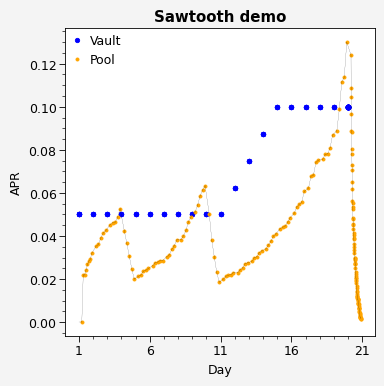

In [8]:
import logging
import matplotlib.pyplot as plt

logging.getLogger().setLevel(logging.WARNING)  # events of this level and above will be tracked

vault_spot_size = 10
spot_colors = ['blue', 'orange']
fig, ax = plt.subplots()
x_data = trades.day
ax.scatter(x_data, trades.vault_apr, label="Vault", s=vault_spot_size, c=spot_colors[0])
prev_apr = trades.loc[trades.run_trade_number==0].pool_apr
prev_time = 0
for day in set(x_data):
    trade_numbers = trades.loc[trades.day==day].run_trade_number
    spot_sizes = np.linspace(0.2, 0.9, len(trade_numbers))
    for trade_idx, trade_number in enumerate(trade_numbers):
        pool_apr = trades.loc[trades.run_trade_number==trade_number].pool_apr
        pool_spot_size = vault_spot_size * 0.5 #spot_sizes[trade_idx]
        time = day + spot_sizes[trade_idx]
        if day == 0 and trade_idx == len(trade_numbers)-1:
            ax.scatter(time, pool_apr, label="Pool", s=pool_spot_size, c=spot_colors[1])
        else:
            ax.scatter(time, pool_apr, s=pool_spot_size, c=spot_colors[1])
        ax.plot([prev_time, time], [prev_apr, pool_apr], color='k', linestyle='-', linewidth=0.1)
        prev_time = time
        prev_apr = pool_apr
ax.set_xlabel("Day")
ax.set_ylabel("APR")
plt.legend()
ax.set_xticks([x for x in range(0, simulator.config.simulator.num_trading_days + 1, 5)])
ax.set_xticklabels([str(x+1) for x in range(0, simulator.config.simulator.num_trading_days + 1, 5)])
ax.set_title("Sawtooth demo")
plt.grid()

In [9]:
fig = output_utils.plot_agent_pnl(trades)

TypeError: 'Simulator' object is not iterable

In [ ]:
fig = output_utils.plot_wallet_returns(simulator, exclude_first_agent=True, xtick_step=20)

In [ ]:
fig = output_utils.plot_pool_apr(simulator)

In [ ]:
fig = output_utils.plot_market_spot_price(simulator)

In [ ]:
fig = output_utils.plot_market_lp_reserves(simulator)

In [ ]:
fig = output_utils.plot_longs_and_shorts(simulator, xtick_step=20)